In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import random

# Define possible values
sectors = ['tech', 'real_estate', 'agriculture']
investment_sizes = ['small', 'medium', 'large']
risk_levels = ['low', 'medium', 'high']
locations = ['riyadh', 'jeddah', 'dammam']
risk_map = {'low': 0, 'medium': 1, 'high': 2}

# Suggested value ranges
past_return_range = (0.07, 0.18)       # Historical returns typically range from 7% to 18%
expected_return_range = (0.08, 0.22)   # Reasonable project return range
# Mapping investment sizes to realistic amounts (just for validation, not used numerically)
investment_size_map = {
    'small': (5000, 20000),
    'medium': (20000, 100000),
    'large': (100000, 1000000)
}

def generate_investors(n=500):
    return pd.DataFrame({
        'sector': np.random.choice(sectors, n),
        'investment_size': np.random.choice(investment_sizes, n),
        'risk_tolerance': np.random.choice(risk_levels, n, p=[0.3, 0.5, 0.2]),  # more likely to be medium
        'location': np.random.choice(locations, n),
        'past_return': np.round(np.random.uniform(*past_return_range, n), 3)
    })

def generate_projects(n=100):
    return pd.DataFrame({
        'sector': np.random.choice(sectors, n),
        'investment_size': np.random.choice(investment_sizes, n),
        'risk_level': np.random.choice(risk_levels, n, p=[0.2, 0.5, 0.3]),  # more medium/high risk projects
        'location': np.random.choice(locations, n),
        'expected_return': np.round(np.random.uniform(*expected_return_range, n), 3)
    })

# Suitability scoring function
def calculate_suitability(investor, project):
    score = 0
    if investor['sector'] == project['sector']:
        score += 2
    if investor['location'] == project['location']:
        score += 1
    if project['expected_return'] >= investor['past_return']:
        score += 1
    if risk_map[project['risk_level']] <= risk_map[investor['risk_tolerance']]:
        score += 2
    if investor['investment_size'] == project['investment_size']:
        score += 1
    return score

# Final decision based on combined score
def final_decision(cos_sim, suitability_score):
    norm_suitability = suitability_score / 7
    final_score = 0.6 * cos_sim + 0.4 * norm_suitability
    if final_score >= 0.7:
        return 1
    else:
        return 0

# Generate data
investors = generate_investors(500)
projects = generate_projects(500)

print("investors:", investors.shape)
print("projects:", projects.shape)

# OneHot encode categorical features
investor_categorical_features = ['sector', 'investment_size', 'risk_tolerance', 'location']
investor_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
investor_cat = investor_encoder.fit_transform(investors_df[investor_categorical_features])

project_categorical_features = ['sector', 'investment_size', 'risk_level', 'location']
project_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
project_cat = project_encoder.fit_transform(projects_df[project_categorical_features])

# Normalize numerical features
investor_scaler = MinMaxScaler()
investor_num = investor_scaler.fit_transform(investors[['past_return']])

project_scaler = MinMaxScaler()
project_num = project_scaler.fit_transform(projects[['expected_return']])

print("project_cat:", project_cat.shape)
print("project_num:", project_num.shape)

print("Investor_cat:", investor_cat.shape)
print("Investor_num:", investor_num.shape)

# Build vectors
investor_vectors = np.hstack([investor_cat, investor_num])
project_vectors = np.hstack([project_cat, project_num])

# Generate results
results = []
for i in range(500):
    inv = investors.iloc[i]
    for j in range(100):
        proj = projects.iloc[j]
        cos_sim = cosine_similarity([investor_vectors[i]], [project_vectors[j]])[0][0]
        suit_score = calculate_suitability(inv, proj)
        label = final_decision(cos_sim, suit_score)
        results.append({
            'investor_sector': inv['sector'],
            'project_sector': proj['sector'],
            'investor_location': inv['location'],
            'project_location': proj['location'],
            'investor_risk': inv['risk_tolerance'],
            'project_risk': proj['risk_level'],
            'investor_size': inv['investment_size'],
            'project_size': proj['investment_size'],
            'past_return': inv['past_return'],
            'expected_return': proj['expected_return'],
            'cosine_similarity': round(cos_sim, 3),
            'suitability_score': suit_score,
            'final_label': label
        })

df_results = pd.DataFrame(results)
df_results.to_csv("investment_suitability_dataset.csv", index=False)
print("Dataset saved as investment_suitability_dataset.csv")

print("df_results:", df_results.shape)
print()
df_results.head(10)

investors: (500, 5)
projects: (500, 5)
project_cat: (500, 12)
project_num: (500, 1)
Investor_cat: (500, 12)
Investor_num: (500, 1)
Dataset saved as investment_suitability_dataset.csv
df_results: (50000, 13)



,investor_sector,project_sector,investor_location,project_location,investor_risk,project_risk,investor_size,project_size,past_return,expected_return,cosine_similarity,suitability_score,final_label
0,real_estate,real_estate,riyadh,dammam,medium,low,medium,large,0.118,0.080,0.000,4,0
1,real_estate,agriculture,riyadh,riyadh,medium,high,medium,small,0.118,0.172,0.299,2,0
2,real_estate,tech,riyadh,dammam,medium,high,medium,small,0.118,0.193,0.306,1,0
3,real_estate,agriculture,riyadh,jeddah,medium,medium,medium,medium,0.118,0.160,0.528,4,0
4,real_estate,tech,riyadh,jeddah,medium,medium,medium,small,0.118,0.136,0.760,3,0
5,real_estate,real_estate,riyadh,dammam,medium,low,medium,small,0.118,0.157,0.528,5,0
6,real_estate,agriculture,riyadh,dammam,medium,medium,medium,small,0.118,0.201,0.533,3,0
7,real_estate,agriculture,riyadh,riyadh,medium,medium,medium,small,0.118,0.139,0.283,4,0
8,real_estate,tech,riyadh,dammam,medium,medium,medium,small,0.118,0.128,0.036,3,0
9,real_estate,tech,riyadh,riyadh,medium,low,medium,small,0.118,0.150,0.289,4,0


In [17]:
df_results['final_label'].value_counts()

final_label
0    47872
1     2128
Name: count, dtype: int64

In [18]:
df_0 = df_results[df_results['final_label'] == 0].sample(n=2000, random_state=42)
df_1 = df_results[df_results['final_label'] == 1]
df_balanced = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)

df_balanced.to_csv("investment_suitability_dataset_balanced.csv", index=False)
print("Dataset saved as investment_suitability_dataset_balanced.csv")

Dataset saved as investment_suitability_dataset_balanced.csv


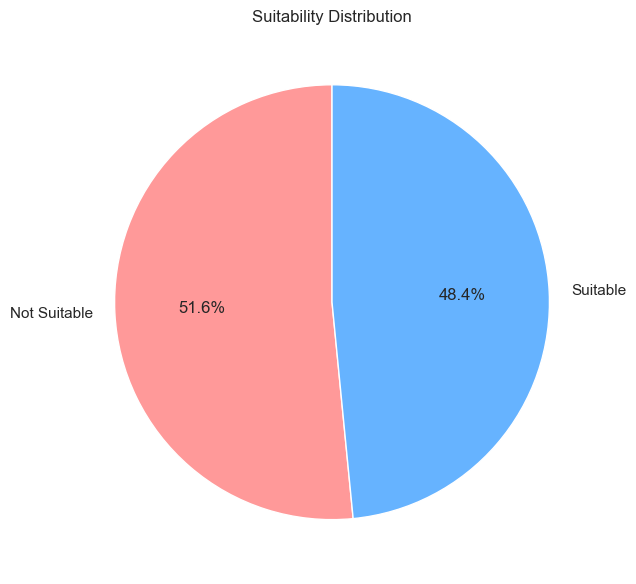

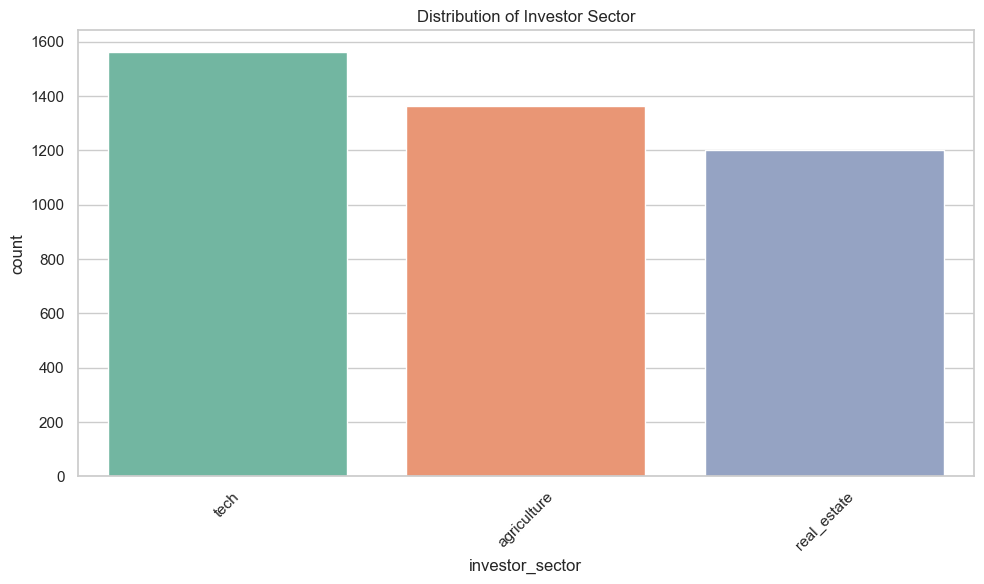

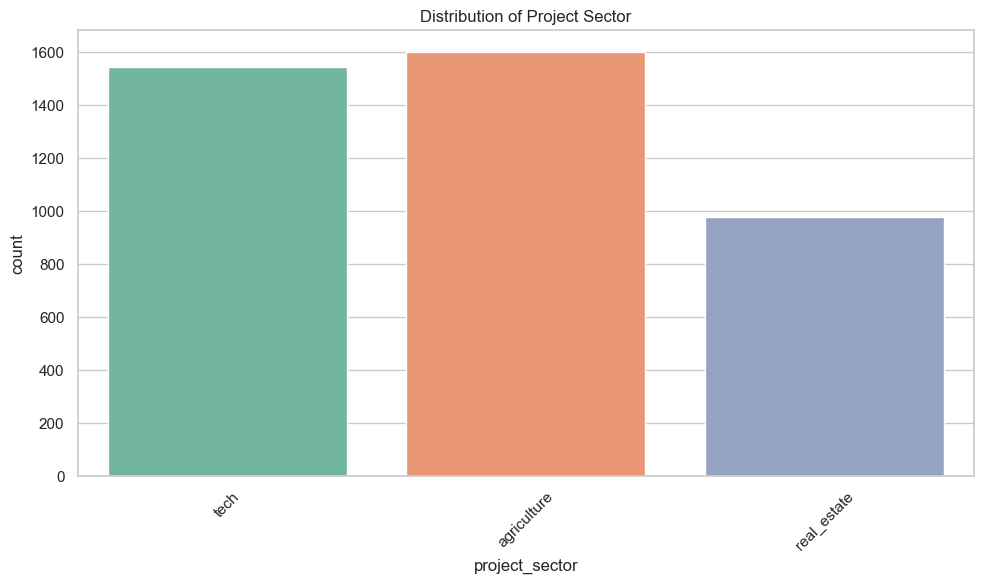

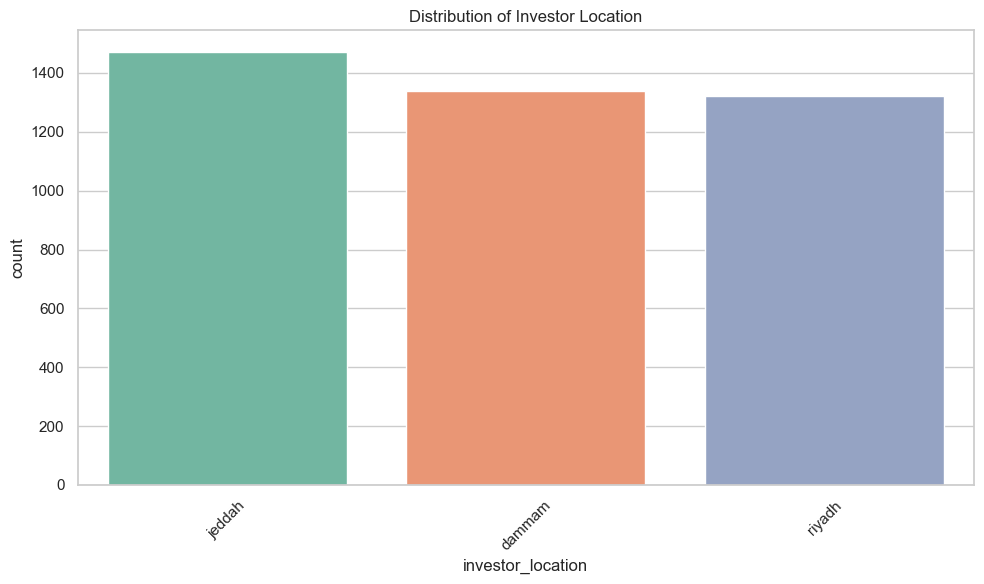

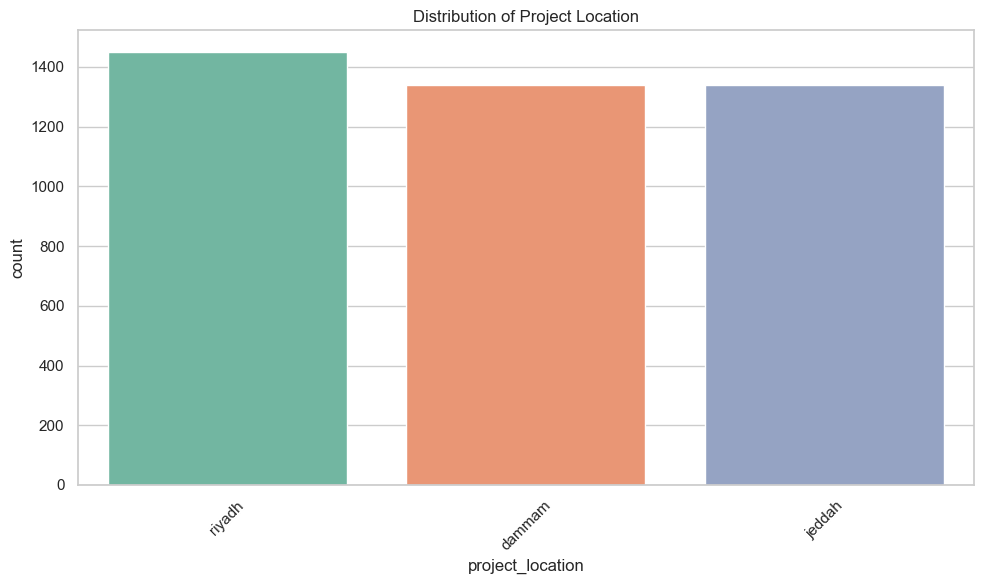

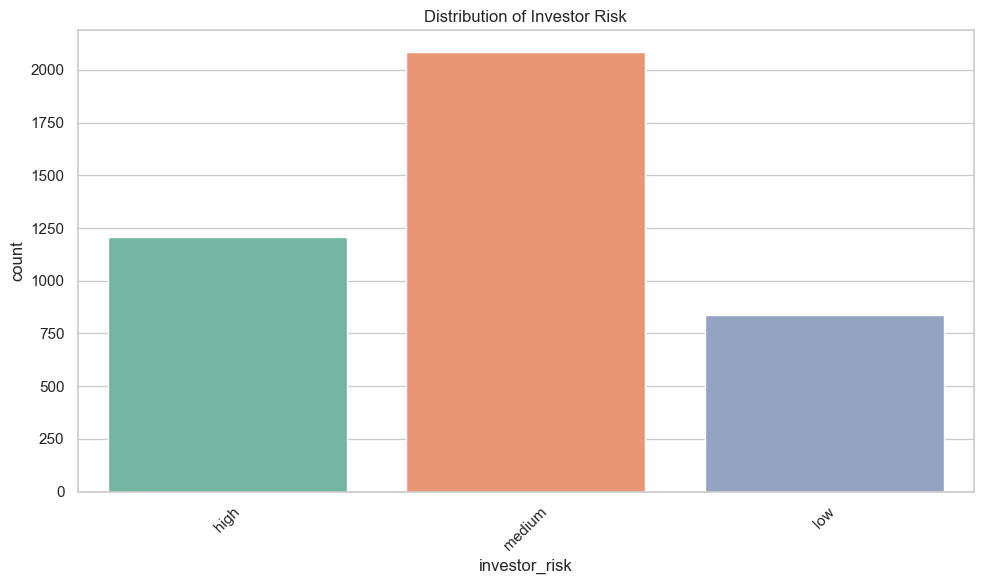

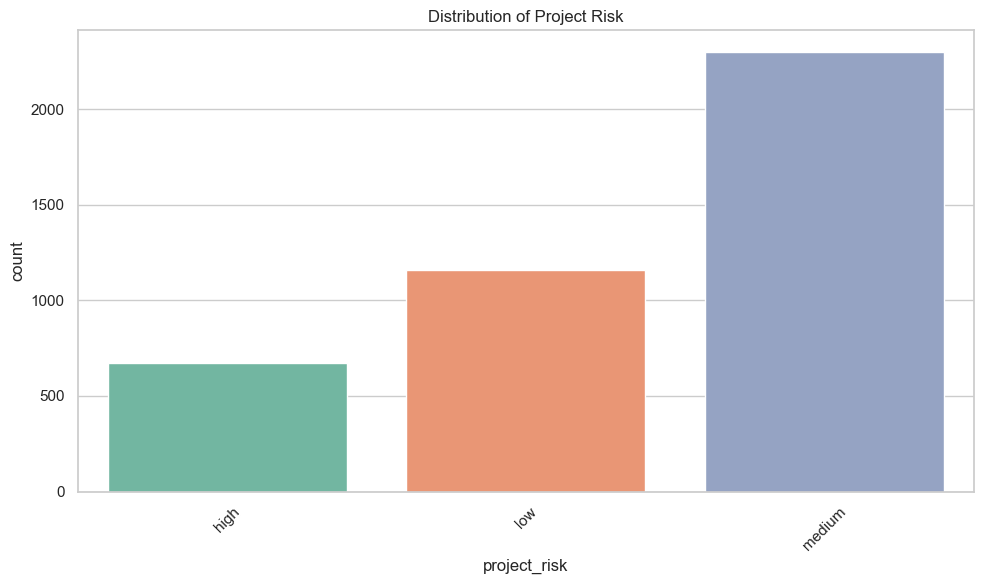

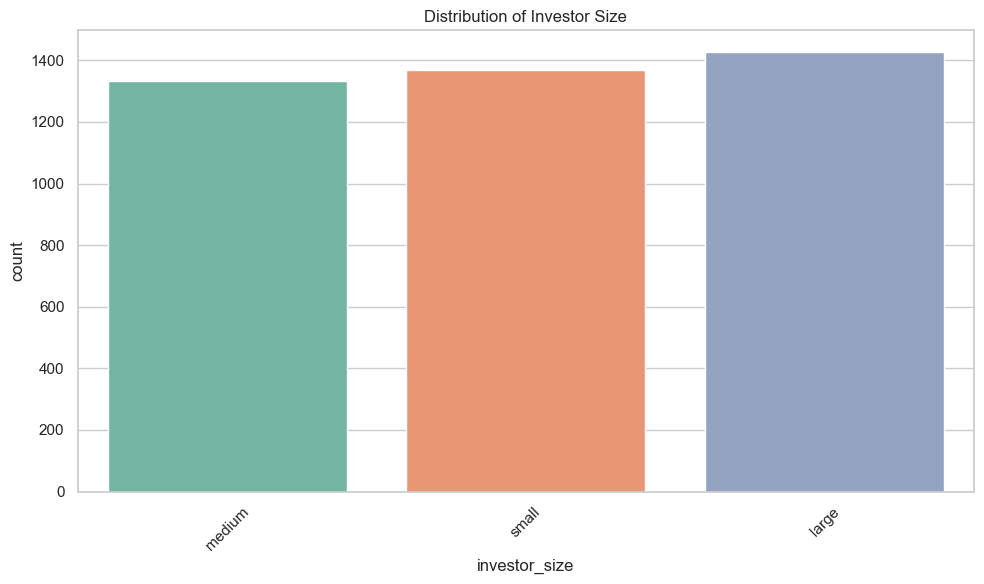

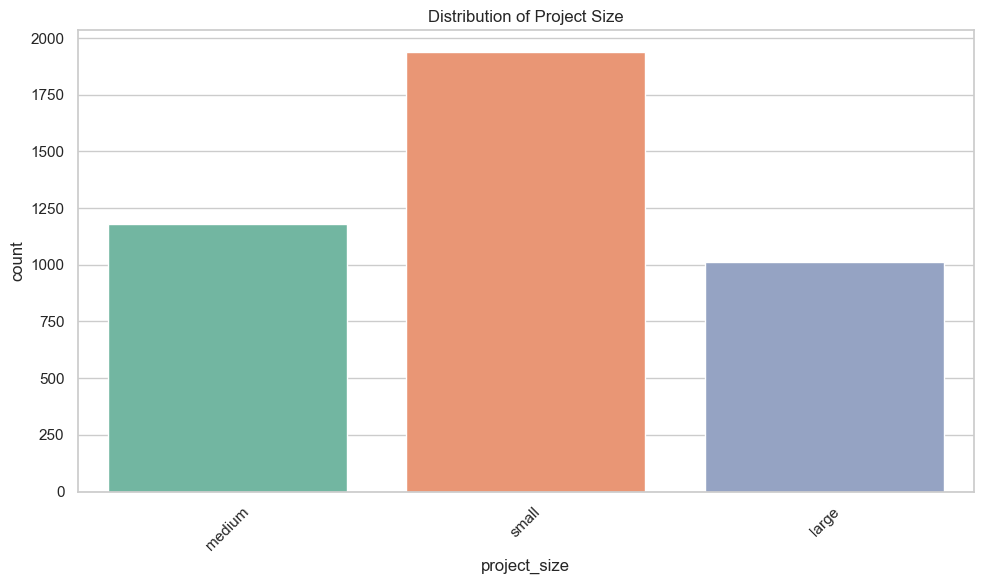

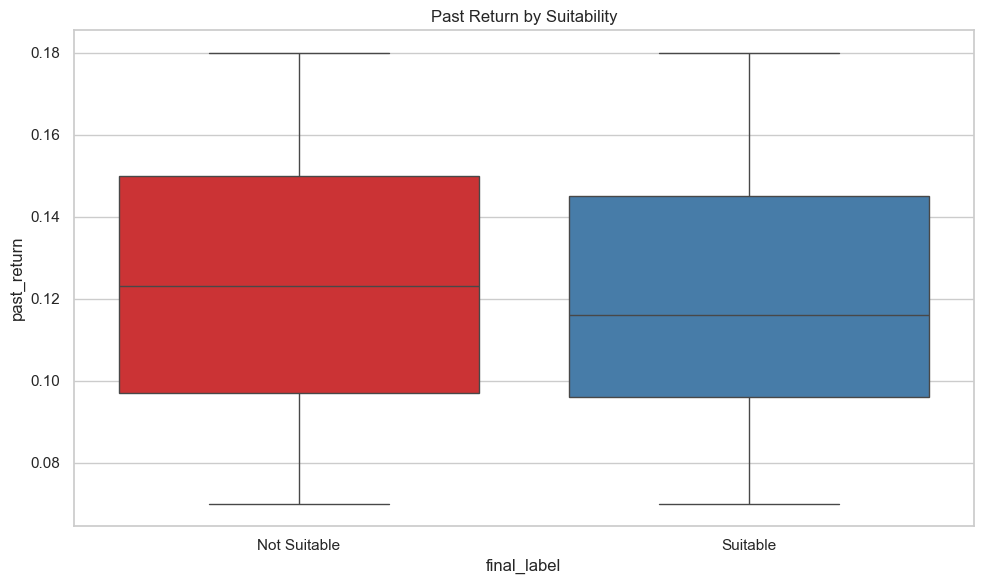

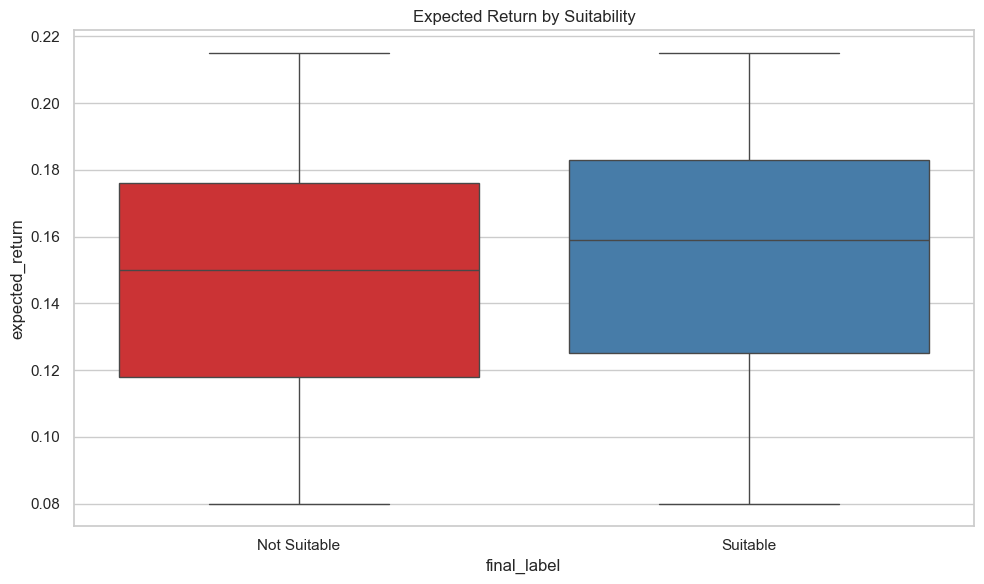

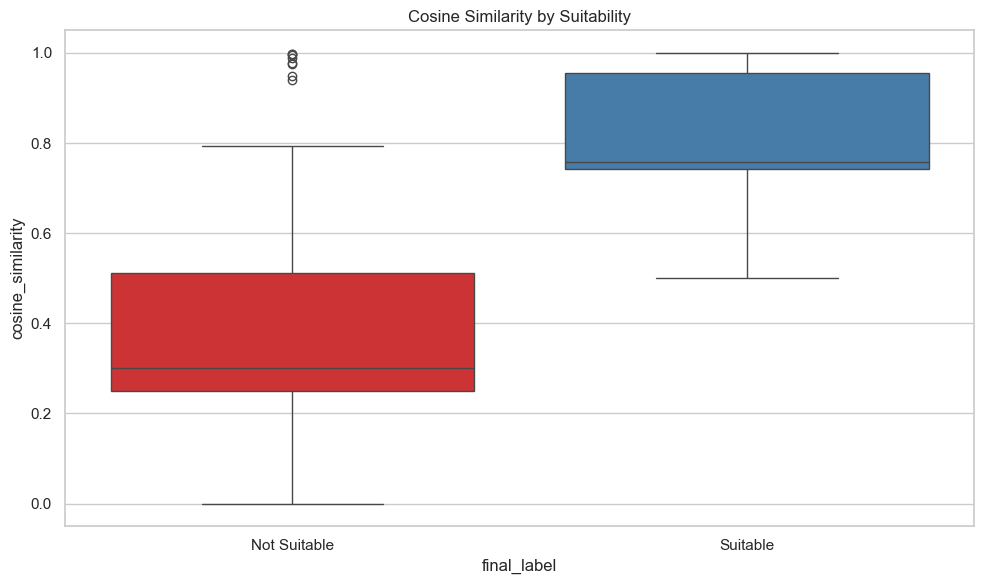

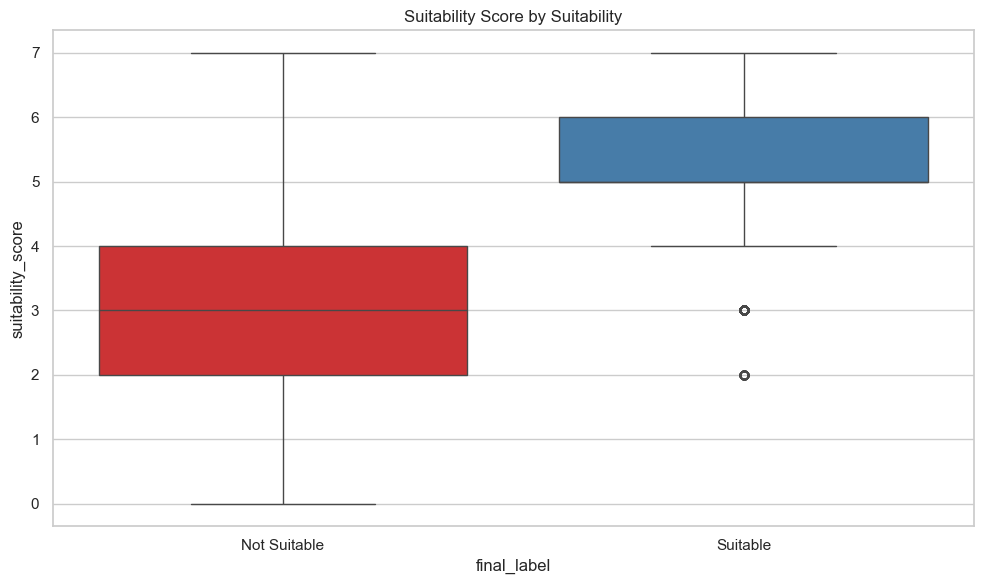

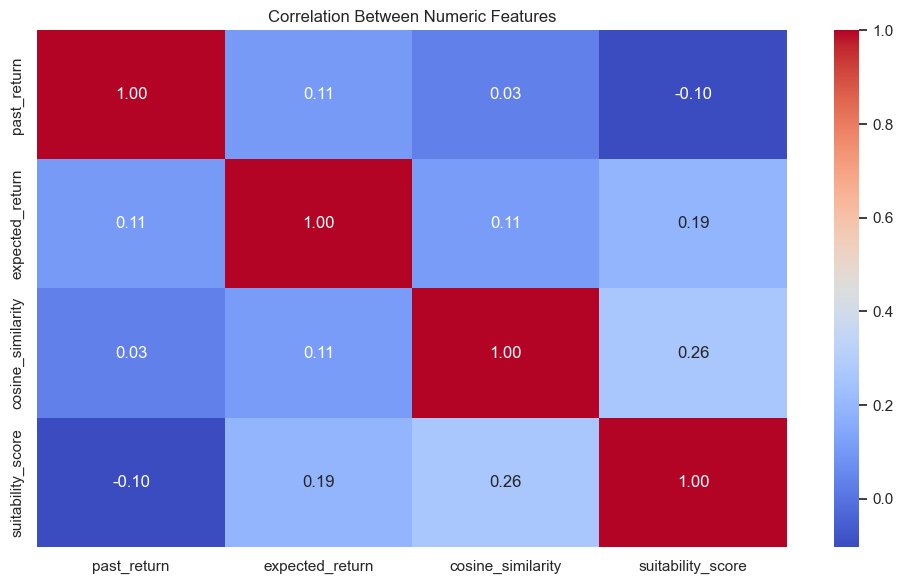

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the generated balanced dataset
df = pd.read_csv("investment_suitability_dataset_balanced.csv")

# General setup for plots
plt.rcParams.update({'figure.figsize': (10, 6), 'axes.titlesize': 14})
sns.set(style="whitegrid")

# Pie chart for suitability label distribution
label_counts = df['final_label'].value_counts()
label_counts.index = ['Not Suitable', 'Suitable']

# Bar plots for categorical feature distribution
categorical_features = [
    'investor_sector', 'project_sector',
    'investor_location', 'project_location',
    'investor_risk', 'project_risk',
    'investor_size', 'project_size'
]

# Distribution of suitability
plt.figure()
label_counts.plot.pie(autopct='%1.1f%%', colors=['#FF9999','#66B3FF'], startangle=90)
plt.title('Suitability Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Categorical distributions
for feature in categorical_features:
    plt.figure()
    sns.countplot(data=df, x=feature, palette='Set2', hue=feature, legend=False)
    plt.title(f'Distribution of {feature.replace("_", " ").title()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Boxplots for numeric features
numeric_features = ['past_return', 'expected_return', 'cosine_similarity', 'suitability_score']
for feature in numeric_features:
    plt.figure()
    sns.boxplot(data=df, x='final_label', y=feature, palette='Set1', hue='final_label', legend=False)
    plt.title(f'{feature.replace("_", " ").title()} by Suitability')
    plt.xticks([0, 1], ['Not Suitable', 'Suitable'])
    plt.tight_layout()
    plt.show()

# Correlation heatmap
plt.figure()
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.show()
